In [1]:
import sys

import astropy.units as u

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


In [2]:
import gammapy
import matplotlib.pylab as plt
import numpy as np
import pyximport
import yaml
from gammapy.datasets import FluxPointsDataset
from gammapy.estimators import FluxPoints
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import Models

In [3]:
from matplotlib import rc
from scipy.interpolate import interp2d

# import random
sys.path.append("/home/katrin/Documents/nuisance_summary/")
sys.path.append("../")
import Dataset_load  # noqa: E402
from Dataset_Creation import sys_dataset  # noqa: E402

print(f"loaded gammapy version: {gammapy.__version__} ")
print("Supposed to be 1.0 (21-12-2022)")
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
pyximport.install()

In [4]:
config = Dataset_load.load_config()
colors = config["colors"]["one"]

In [5]:
savefig = 1
picformat = "png"

## Read dataset

In [6]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
dataset_asimov = Dataset_load.create_asimov(
    model="pl", source="PKSflare", parameters=Parameters([scaled_amplitude])
)

shift = 0.1
tilt = 0.02

sys_ = sys_dataset(
    dataset_asimov=dataset_asimov,
    shift=0,
    tilt=0,
    bias=0,
    resolution=0,
    rnd=False,
    e_reco_creation=10,
)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
# addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
# 'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(
    penalising_invcovmatrix,
    [1 / zero**2, 1 / zero**2, 1 / shift**2, 1 / tilt**2],
)
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_asimov_N.irf_model.e_reco_model.parameters.freeze_all()
dataset_asimov_N.irf_model.parameters["tilt_nuisance"].frozen = False

a_unit = dataset_asimov_N.models.parameters["amplitude"].unit

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz
0.02


In [9]:


def compute_fraction(Ls_new, x_new, y_new, threshold, plot=False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    inside = Ls_new * (Ls_new >= offset)
    fraction_inside = np.sum(inside) / tot_int
    if plot:
        fig, ax = plt.subplots(
            1,
            1,
        )
        im = ax.pcolormesh(x_new, y_new, Ls_new)
        fig.colorbar(im)
        ax.set_title(f"frac inside : {fraction_inside * 100:.4} %")

        ax.contour(
            x_new, y_new, Ls_new, colors=("gold",), levels=[Ls_new.min() + threshold]
        )
    return fraction_inside


def plot_L(
    Ls_new,
    x_new,
    y_new,
    threshold,
    find_min,
    color="red",
    ax=None,
    fig=None,
    cbar=True,
    cmap="viridis",
):
    index_min, index_max, ampli_min, ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min=find_min
    )
    if ax is None:
        fig, ax = plt.subplots(
            1,
            1,
        )

    im = ax.pcolormesh(x_new, y_new, Ls_new, cmap=cmap, rasterized=True)
    if cbar:
        fig.colorbar(im)

    CS = ax.contour(
        x_new, y_new, Ls_new, colors=(color,), levels=[Ls_new.min() + threshold]
    )
    # ax.clabel(CS, CS.levels, inline=True, fmt='$1\\sigma$', fontsize=12)

    plot_errors(
        ax,
        x_new,
        y_new,
        index_min,
        index_max,
        ampli_min,
        ampli_max,
        index_best,
        ampli_best,
        color,
    )

    ax.plot(ampli_best, index_best, "x", color=color)

    ax.set_ylabel(f"Amplitude [{a_unit}]")
    ax.set_xlabel("Index []")
    return CS


def plot_errors(
    ax,
    x_new,
    y_new,
    index_min,
    index_max,
    ampli_min,
    ampli_max,
    index_best,
    ampli_best,
    color,
):
    linewidth = 2

    ax.hlines(
        y=index_min,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.hlines(
        y=index_max,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )

    ax.vlines(
        x=ampli_min,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.vlines(
        x=ampli_max,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )


def compute_errors(Ls_new, x_new, y_new, threshold, find_min):
    offset = Ls_new.min() + threshold
    if offset > 0:
        inside = Ls_new * (Ls_new < offset)
    else:
        inside = Ls_new * (Ls_new >= offset)
    if find_min:  # find min:
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]

    else:  # find max
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]

    delta_bin = (x_new[1] - x_new[0]) / 2
    ampli_min = x_new[np.min(pos[1])] - delta_bin
    ampli_max = x_new[np.max(pos[1])] + delta_bin
    ampli_best += delta_bin

    delta_bin = (y_new[1] - y_new[0]) / 2
    index_min = y_new[np.min(pos[0])] - delta_bin
    index_max = y_new[np.max(pos[0])] + delta_bin
    index_best += delta_bin

    return index_min, index_max, ampli_min, ampli_max, index_best, ampli_best

## Varying the Exposure

In [10]:
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
stat_sums = infos[:N_max, 2]


# amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:N_max, 0:2]
indices = pars[:N_max, 2:4]
norms = pars[:N_max, 4:6]
tilts = pars[:N_max, 6:8]

valuies = [norms, amplitudes, indices]

1000


In [11]:
%%time
dataset_asimov.models = Models.read("data/1_model_cor.yml")

path = f"data/2_model_nui_{0.0}_tilt_{0}.yml"
dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)
dataset_asimov_N.models.parameters["tilt_nuisance"].frozen = False

CPU times: user 95.2 ms, sys: 18.5 ms, total: 114 ms
Wall time: 135 ms


In [12]:
valuies_asimov = [
    [
        1,  # dataset_asimov.models[1].parameters['norm'].value,
        0,
    ],  # dataset_asimov.models[1].parameters['norm'].error],
    [
        dataset_asimov.models[0].parameters["amplitude"].value,
        dataset_asimov.models[0].parameters["amplitude"].error,
    ],
    [
        dataset_asimov.models[0].parameters["index"].value,
        dataset_asimov.models[0].parameters["index"].error,
    ],
]


valuies_asimov_N = [
    [
        dataset_asimov_N.models.parameters["norm"].value,
        dataset_asimov_N.models.parameters["norm"].error,
    ],
    [
        dataset_asimov_N.models.parameters["amplitude"].value,
        dataset_asimov_N.models.parameters["amplitude"].error,
    ],
    [
        dataset_asimov_N.models.parameters["index"].value,
        dataset_asimov_N.models.parameters["index"].error,
    ],
]
print(valuies_asimov_N)

[[0.999998904429196, 0.0015650159932837277], [1.0000146253992263e-12, 1.2301815621327898e-13], [2.299062001149006, 0.05006344522830877]]


## Asimov Likelihood

In [13]:
%%time
computing = 0
if computing:
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run([dataset_asimov])
    result_cor = fit_cor.run([dataset_asimov_N])

    x = dataset_asimov.models.parameters["amplitude"]
    y = dataset_asimov.models.parameters["index"]
    x.scan_n_sigma = 5
    y.scan_n_sigma = 2
    x.scan_n_values = 11
    y.scan_n_values = 10

    contour = fit_cor.stat_surface([dataset_asimov], x, y, reoptimize=True)

    contour_write = dict()
    for k in contour.keys():
        print(k)
        if k != "fit_results":
            contour_write[k] = contour[k].tolist()

    with open("data/7c_contour.yml", "w") as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)

else:
    with open("data/7c_contour.yml", "r") as stream:
        contour = yaml.safe_load(stream)
source = list(contour.keys())[0][:-24]
amplix__ = contour[f"{source}.spectral.amplitude_scan"]
indexy__ = contour[f"{source}.spectral.index_scan"]
N_new = 110
N_new_y = 100
amplix__new = np.linspace(amplix__[0], amplix__[-1], N_new)
indexy__new = np.linspace(indexy__[0], indexy__[-1], N_new_y)


f = interp2d(
    x=indexy__,
    y=amplix__,
    z=contour["stat_scan"],
    kind="cubic",
    fill_value=None,
    bounds_error=False,
)
data_contour = f(indexy__new, amplix__new)

CPU times: user 8.11 ms, sys: 114 µs, total: 8.22 ms
Wall time: 15.6 ms


min index: 2.298130923528755
min amplitude: 9.978730424609967e-13


Text(0.5, 1.0, 'Likelihood')

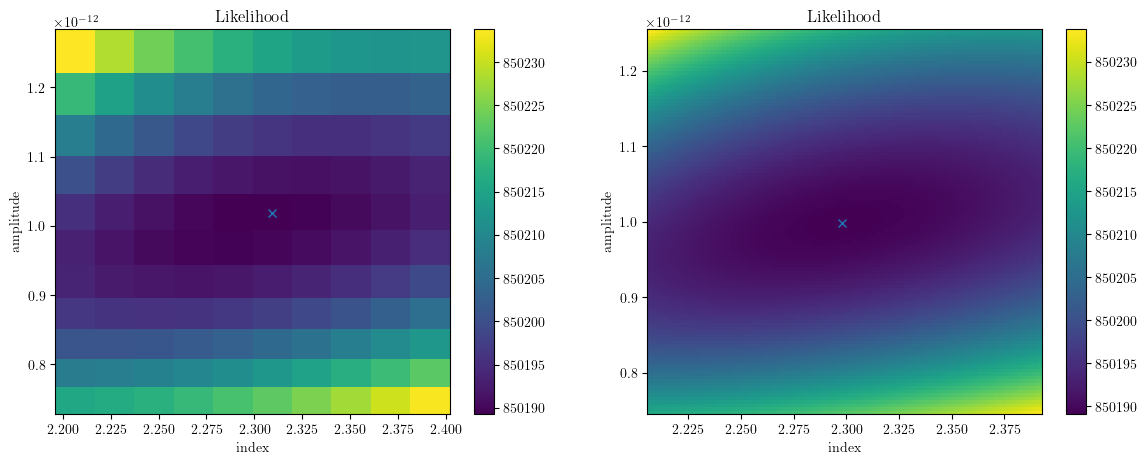

In [14]:
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(14, 5))


im = ax1.pcolormesh(indexy__, amplix__, contour["stat_scan"])
dddd = np.array(contour["stat_scan"])
ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel(
    "index",
)
ax1.set_title("Likelihood")


im = ax.pcolormesh(indexy__new, amplix__new, data_contour)
dddd = np.array(data_contour)
ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best)
print("min amplitude:", ampli_best)

ax.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel(
    "index",
)
ax.set_title("Likelihood")

9.492446049288172e-13 1.0511327597581456e-12 2.2522700415893526 2.3458636782003772 1.0001886823434815e-12 2.2990668598948654


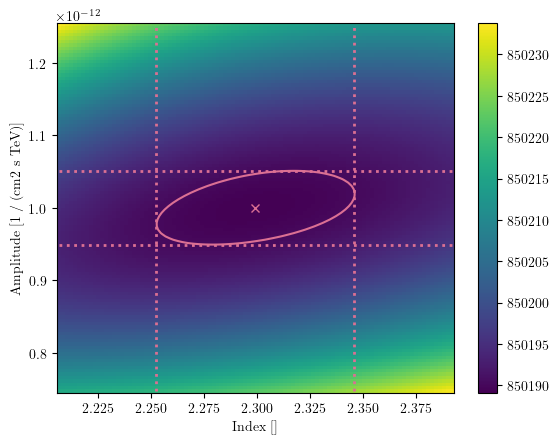

In [15]:
threshold_contour = 1

(
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
) = compute_errors(
    data_contour, indexy__new, amplix__new, threshold_contour, find_min=True
)
print(
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
)
CS = plot_L(
    data_contour,
    indexy__new,
    amplix__new,
    threshold_contour,
    find_min=True,
    color=colors[2],
)

dat = CS.allsegs[0][0]

## Asimov Likelihood N

In [16]:
%%time
if computing:
    x_N = dataset_asimov_N.models.parameters["amplitude"]
    y_N = dataset_asimov_N.models.parameters["index"]

    x_N.scan_values = x.scan_values
    y_N.scan_values = y.scan_values

    contour_N = fit_cor.stat_surface([dataset_asimov_N], x_N, y_N, reoptimize=True)

    contour_write = dict()
    for k in contour_N.keys():
        print(k)
        if k != "fit_results":
            contour_write[k] = contour_N[k].tolist()

    with open("data/7c_contour_N.yml", "w") as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)

else:
    with open("data/7c_contour_N.yml", "r") as stream:
        contour_N = yaml.safe_load(stream)

# print(contour_N)
source_N = list(contour_N.keys())[0][:-24]

amplix___N = contour_N[f"{source_N}.spectral.amplitude_scan"]
indexy___N = contour_N[f"{source_N}.spectral.index_scan"]
amplix__new_N = np.linspace(amplix___N[0], amplix___N[-1], N_new)
indexy__new_N = np.linspace(indexy___N[0], indexy___N[-1], N_new_y)


f = interp2d(
    x=indexy___N,
    y=amplix___N,
    z=contour_N["stat_scan"],
    kind="cubic",
    fill_value=None,
    bounds_error=False,
)
data_contour_N = f(indexy__new_N, amplix__new_N)

CPU times: user 6.58 ms, sys: 915 µs, total: 7.5 ms
Wall time: 17.2 ms


min index: 2.298130923528755
min amplitude: 9.978730424609967e-13


Text(0.5, 1.0, 'Likelihood')

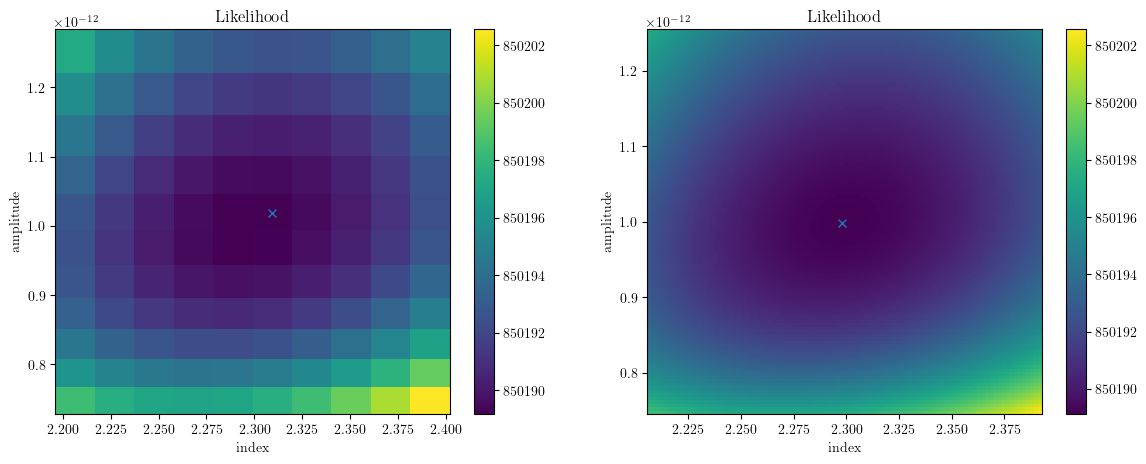

In [17]:
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(14, 5))

im = ax1.pcolormesh(indexy___N, amplix___N, contour_N["stat_scan"])
dddd = np.array(contour_N["stat_scan"])
ampli_best_N = amplix___N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy___N[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best_N, ampli_best_N, "x")
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel(
    "index",
)
ax1.set_title("Likelihood")


im = ax.pcolormesh(indexy__new_N, amplix__new_N, data_contour_N)
dddd = np.array(data_contour_N)
ampli_best_N = amplix__new_N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy__new_N[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best_N)
print("min amplitude:", ampli_best_N)

ax.plot(index_best_N, ampli_best_N, "x")
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel(
    "index",
)
ax.set_title("Likelihood")

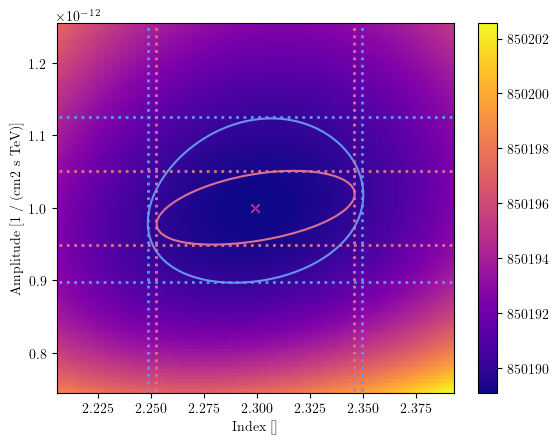

In [18]:
(
    ampli_min_asimov_N,
    ampli_max_asimov_N,
    index_min_asimov_N,
    index_max_asimov_N,
    ampli_best_asimov_N,
    index_best_asimov_N,
) = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N, threshold_contour, find_min=True
)
cmap = "plasma"
CS_N = plot_L(
    data_contour_N,
    indexy__new_N,
    amplix__new_N,
    threshold_contour,
    find_min=True,
    color=colors[3],
    cmap=cmap,
)
ax = plt.gca()
plot_errors(
    ax,
    indexy__new,
    amplix__new,
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
    colors[2],
)

dat_N = CS_N.allsegs[0][0]
ax.clabel(CS, CS.levels, inline=True, fmt="$1$", fontsize=12)

plt.plot(
    dat[:, 0],
    dat[:, 1],
    color=colors[2],
)

plt.plot(index_best_asimov_N, ampli_best_asimov_N, "x", color=colors[3])
plt.plot(index_best_asimov, ampli_best_asimov, "x", color=colors[0])
fig = plt.gcf()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{shift}." + picformat)

## Compute fraction of within

In [19]:
def fraction_within(lower_lim, upper_lim, data):
    is_within = []
    for d in data:
        larger = np.all(d[0] >= lower_lim)
        smaller = np.all(d[0] <= upper_lim)
        is_within.append(larger and smaller)

    return np.count_nonzero(is_within) / len(data)

In [20]:
# std best fit, nui best fit, ...
within_norm = [
    fraction_within(
        valuies_asimov[0][0] - valuies_asimov[0][1],
        valuies_asimov[0][0] + valuies_asimov[0][1],
        norms,
    ),
    fraction_within(
        valuies_asimov_N[0][0] - valuies_asimov_N[0][1],
        valuies_asimov_N[0][0] + valuies_asimov_N[0][1],
        norms,
    ),
    0.0,
    0.0,
]

within_amplitude = [
    fraction_within(
        valuies_asimov[1][0] - valuies_asimov[1][1],
        valuies_asimov[1][0] + valuies_asimov[1][1],
        amplitudes,
    ),
    fraction_within(
        valuies_asimov_N[1][0] - valuies_asimov_N[1][1],
        valuies_asimov_N[1][0] + valuies_asimov_N[1][1],
        amplitudes,
    ),
    fraction_within(ampli_min_asimov, ampli_max_asimov, amplitudes),
    fraction_within(ampli_min_asimov_N, ampli_max_asimov_N, amplitudes),
]

within_index = [
    fraction_within(
        valuies_asimov[2][0] - valuies_asimov[2][1],
        valuies_asimov[2][0] + valuies_asimov[2][1],
        indices,
    ),
    fraction_within(
        valuies_asimov_N[2][0] - valuies_asimov_N[2][1],
        valuies_asimov_N[2][0] + valuies_asimov_N[2][1],
        indices,
    ),
    fraction_within(index_min_asimov, index_max_asimov, indices),
    fraction_within(index_min_asimov_N, index_max_asimov_N, indices),
]

withins = [within_norm, within_amplitude, within_index]
print(withins)

[[0.0, 0.671, 0.0, 0.0], [0.345, 0.721, 0.348, 0.666], [0.655, 0.696, 0.662, 0.698]]


0 Best Fit BKG Norm
1 Best Fit Amplitude
2 Best Fit Index


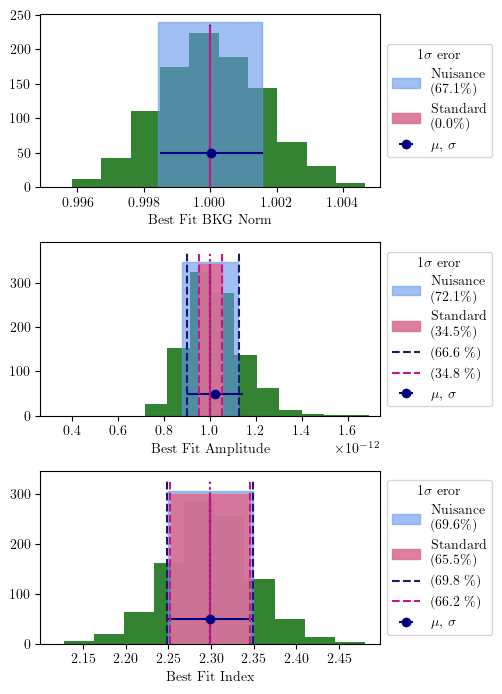

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(4, 7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]
legends = [
    "Nuisance",
    "Standard",
]


axs[2].errorbar(
    x=np.mean(indices[:, 0]),
    y=50,
    xerr=np.std(indices[:, 0]),
    fmt="o",
    color="navy",
    label="$\\mu$, $\\sigma$",
)
axs[1].errorbar(
    x=np.mean(amplitudes[:, 0]),
    y=50,
    xerr=np.std(amplitudes[:, 0]),
    fmt="o",
    color="navy",
    label="$\\mu$, $\\sigma$",
)
axs[0].errorbar(
    x=np.mean(norms[:, 0]),
    y=50,
    xerr=np.std(norms[:, 0]),
    fmt="o",
    color="navy",
    label="$\\mu$, $\\sigma$",
)

for i, v in enumerate(valuies):
    print(i, xlabels[i])
    axs[i].hist(v[1:, 0], color="darkgreen", alpha=0.8)
    ylim = axs[i].get_ylim()
    delta_ylim = 5

    axs[i].vlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color=colors[1],
        linestyle="dashed",
    )
    axs[i].fill_between(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=0.6,
        color=colors[3],
        label=legends[0] + f" \n({withins[i][1]*100 :.3}\\%)",
    )
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
    axs[i].fill_between(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=0.9,
        color=colors[2],
        label=legends[1] + f" \n({withins[i][0]*100 :.3}\\%)",
    )

    axs[i].set_xlabel(xlabels[i])

    x = axs[i].get_xlim()
    deltax = np.max([valuies_asimov[i][0] - x[0], x[1] - valuies_asimov[i][0]])
    axs[i].set_xlim(valuies_asimov[i][0] - deltax, valuies_asimov[i][0] + deltax)

ylim = axs[1].get_ylim()
delta_ylim = 9
axs[1].vlines(
    ampli_min_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dashed",
)
axs[1].vlines(
    ampli_max_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dashed",
    label=f"({withins[1][3]*100:.3} \\%)",
)
axs[1].vlines(
    ampli_best_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dotted",
)

delta_ylim = 2
axs[1].vlines(
    ampli_min_asimov, ylim[0], ylim[1] + delta_ylim, color=colors[0], linestyle="dashed"
)
axs[1].vlines(
    ampli_max_asimov,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[0],
    linestyle="dashed",
    label=f"({withins[1][2]*100:.3} \\%)",
)
axs[1].vlines(
    ampli_best_asimov,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[0],
    linestyle="dotted",
)

ylim = axs[2].get_ylim()
delta_ylim = 9

axs[2].vlines(
    index_min_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dashed",
)
axs[2].vlines(
    index_max_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dashed",
    label=f"({withins[2][3]*100:.3} \\%)",
)
axs[2].vlines(
    index_best_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dotted",
)
delta_ylim = 2
axs[2].vlines(
    index_min_asimov, ylim[0], ylim[1] + delta_ylim, color=colors[0], linestyle="dashed"
)
axs[2].vlines(
    index_max_asimov,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[0],
    linestyle="dashed",
    label=f"({withins[2][2]*100:.3} \\%)",
)
axs[2].vlines(
    index_best_asimov,
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[0],
    linestyle="dotted",
)
plt.tight_layout()
for a in axs:
    a.legend(title="1$\\sigma$ eror", loc="center left", bbox_to_anchor=(1, 0.5))

## 2D Histograms Poission

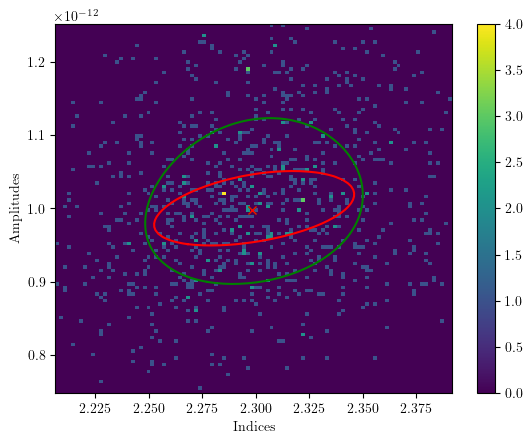

In [22]:
N_bins = N_new + 1
N_bins_y = N_new_y + 1

amplitude_bin = np.linspace(amplix__new_N[0], amplix__new_N[-1], N_bins)
index_bin = np.linspace(indexy__new_N[0], indexy__new_N[-1], N_bins_y)

amplitudes_data = valuies[1][:, 0]
indices_data = valuies[2][:, 0]
data_N_new, (abins, ibins) = np.histogramdd(
    (amplitudes_data, indices_data), (amplitude_bin, index_bin)
)

fig, ax = plt.subplots()
im = ax.pcolormesh(ibins, abins, data_N_new)

fig.colorbar(im, ax=ax)
ax.plot(index_best_N, ampli_best_N, "x", color="green")
ax.plot(index_best, ampli_best, "x", color="red")

ax.set_ylabel("Amplitudes")
ax.set_xlabel("Indices")
plt.plot(dat[:, 0], dat[:, 1], color="red")
plt.plot(dat_N[:, 0], dat_N[:, 1], color="green")

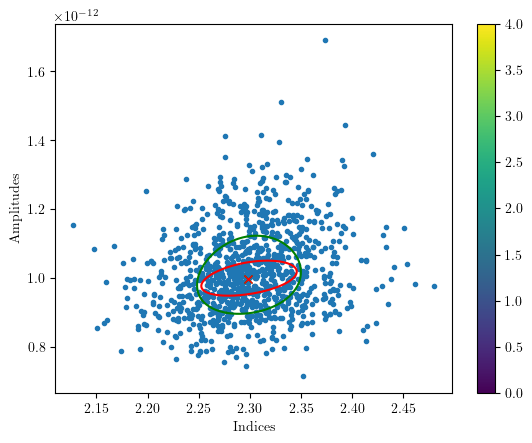

In [23]:
N_bins = N_new + 1
N_bins_y = N_new_y + 1

amplitude_bin = np.linspace(amplix__new_N[0], amplix__new_N[-1], N_bins)
index_bin = np.linspace(indexy__new_N[0], indexy__new_N[-1], N_bins_y)

amplitudes_data = valuies[1][:, 0]
indices_data = valuies[2][:, 0]
data_N_new, (abins, ibins) = np.histogramdd(
    (amplitudes_data, indices_data), (amplitude_bin, index_bin)
)

fig, ax = plt.subplots()
plt.scatter(indices_data, amplitudes_data, marker=".")

fig.colorbar(im, ax=ax)
ax.plot(index_best_N, ampli_best_N, "x", color="green")
ax.plot(index_best, ampli_best, "x", color="red")

ax.set_ylabel("Amplitudes")
ax.set_xlabel("Indices")
plt.plot(dat[:, 0], dat[:, 1], color="red")
plt.plot(dat_N[:, 0], dat_N[:, 1], color="green")

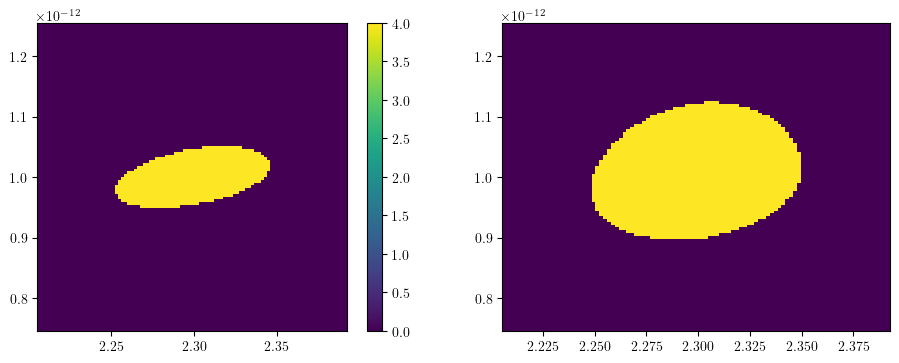

In [24]:
d_N = (data_contour_N < (1 + data_contour_N.min())).reshape(np.shape(data_contour_N))
d = (data_contour < (1 + data_contour.min())).reshape(np.shape(data_contour))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
fig.colorbar(im, ax=ax1)
ax1.pcolormesh(indexy__new_N, amplix__new_N, d)
ax2.pcolormesh(indexy__new_N, amplix__new_N, d_N)

In [25]:
fraction = np.sum(data_N_new * d) / N * 100
fraction_N = np.sum(data_N_new * d_N) / N * 100

Text(0.5, 1.0, 'Within $1\\sigma$ Nuisance: 40.8 \\%')

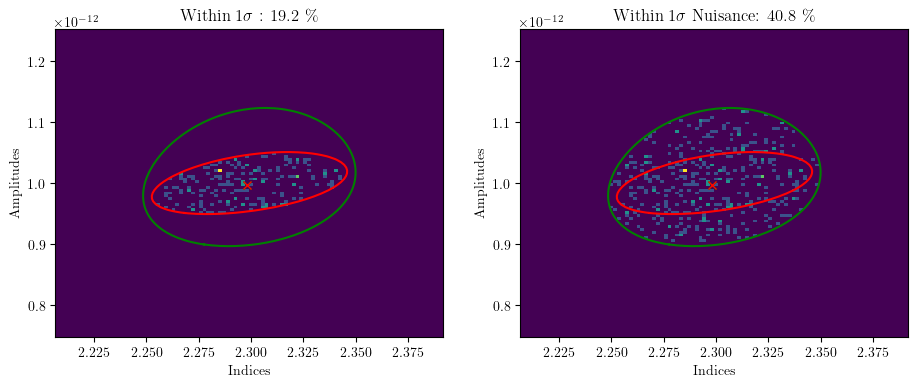

In [26]:
data_N_new, (abins, ibins) = np.histogramdd(
    (amplitudes_data, indices_data), (amplitude_bin, index_bin)
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

im = ax1.pcolormesh(ibins, abins, data_N_new * d)
im = ax2.pcolormesh(ibins, abins, data_N_new * d_N)

for ax in (ax1, ax2):
    ax.plot(index_best_N, ampli_best_N, "x", color="green")
    ax.plot(index_best, ampli_best, "x", color="red")

    ax.set_ylabel("Amplitudes")
    ax.set_xlabel("Indices")
    ax.plot(dat[:, 0], dat[:, 1], color="red")
    ax.plot(dat_N[:, 0], dat_N[:, 1], color="green")

ax1.set_title(f"Within $1\\sigma$ : {fraction:.3} \\%")
ax2.set_title(f"Within $1\\sigma$ Nuisance: {fraction_N:.3} \\%")

## Special Plot

color_rnd = "sandybrown"
color_rnd_err = "darkorange"
alpha_nui = 0.7
alpha_st = 0.5
legends = ["With Sys.:\\n", "Without Sys.:\\n"]

(
    ampli_min_asimov_N,
    ampli_max_asimov_N,
    index_min_asimov_N,
    index_max_asimov_N,
    ampli_best_asimov_N,
    index_best_asimov_N,
) = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N, threshold_contour, find_min=True
)

fig, axs = plt.subplots(
    2,
    2,
    gridspec_kw={"height_ratios": [3, 5], "width_ratios": [5, 3]},
    figsize=(5.0, 5.0),
)
axs_L = axs[1][0]
axs_i = axs[0][0]
axs_a = axs[1][1]
axs[0, -1].axis("off")

cmap = "plasma"

CS_N = plot_L(
    data_contour_N,
    indexy__new_N,
    amplix__new_N,
    threshold_contour,
    find_min=True,
    color=colors[3],
    ax=axs_L,
    fig=fig,
    cbar=False,
    cmap=cmap,
)

dat_N = CS_N.allsegs[0][0]
axs_L.plot(dat[:, 0], dat[:, 1], color=colors[2])
axs_L.plot(index_best_asimov_N, ampli_best_asimov_N, "x", color=colors[3])
axs_L.plot(index_best_asimov, ampli_best_asimov, "x", color=colors[2])

plot_errors(
    axs_L,
    indexy__new,
    amplix__new,
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
    colors[2],
)

xlims = [None, amplix__new_N, indexy__new_N]

ampli
a = axs_a
i = 1
a.hist(
    valuies[i][1:, 0],
    color=color_rnd,
    alpha=0.8,
    bins=np.linspace(xlims[i][0], xlims[i][-1], 10),
    orientation="horizontal",
)
ylim = a.get_xlim()
delta_ylim = 5
a.hlines(
    valuies_asimov_N[i][0],
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dashed",
)
a.fill_betweenx(
    [
        valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
        valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
    ],
    ylim[0],
    ylim[1] + delta_ylim,
    alpha=alpha_nui,
    color=colors[3],
    label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
)
a.hlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
a.fill_betweenx(
    [
        valuies_asimov[i][0] - valuies_asimov[i][1],
        valuies_asimov[i][0] + valuies_asimov[i][1],
    ],
    ylim[0],
    ylim[1],
    alpha=alpha_st,
    color=colors[2],
    label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
)
a.set_xlabel("")
a.set_ylim(axs_L.get_ylim()[0], axs_L.get_ylim()[1])
yy = a.get_xlim()[1]
print(f"amplitudes: {np.mean(amplitudes[:,0])} pm {np.std(amplitudes[:,0])}")
a.errorbar(
    x=yy / 3,
    y=np.mean(amplitudes[:, 0]),
    yerr=np.std(amplitudes[:, 0]),
    fmt="o",
    color=color_rnd_err,
    label="",
)

a.set_yticklabels([])
a.set_yticks([])
a.legend()
index
a = axs_i
i = 2
a.hist(
    valuies[i][1:, 0],
    color=color_rnd,
    alpha=0.8,
    bins=np.linspace(xlims[i][0], xlims[i][-1], 10),
)
ylim = a.get_ylim()
delta_ylim = 5
a.vlines(
    valuies_asimov_N[i][0],
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dashed",
)
a.fill_between(
    [
        valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
        valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
    ],
    ylim[0],
    ylim[1] + delta_ylim,
    alpha=alpha_nui,
    color=colors[3],
    label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
)
a.vlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
a.fill_between(
    [
        valuies_asimov[i][0] - valuies_asimov[i][1],
        valuies_asimov[i][0] + valuies_asimov[i][1],
    ],
    ylim[0],
    ylim[1],
    alpha=alpha_st,
    color=colors[2],
    label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
)
a.set_xlabel(xlabels[i])
yy = a.get_ylim()[1]
print(f"index: {np.mean(indices[:,0])} pm {np.std(indices[:,0])}")
a.errorbar(
    x=np.mean(indices[:, 0]),
    y=yy / 3,
    xerr=np.std(indices[:, 0]),
    fmt="o",
    color=color_rnd_err,
    label="",
)
a.set_xlim(axs_L.get_xlim()[0], axs_L.get_xlim()[1])
a.set_xlabel("")
a.set_xticklabels([])
a.set_xticks([])


plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.08, hspace=0.08)
a.legend()  # bbox_to_anchor=(1, 0.7))
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{shift}_dist." + picformat)
    fig.savefig(f"plots/7c_L_contour_{shift}_dist." + "png")
print(N)


color_rnd = "sandybrown"
color_rnd_err = "darkorange"
alpha_nui = 0.7
alpha_st = 0.5
legends = ["With Sys.:\n", "Without Sys.:\n"]

nbins = 20

(
    ampli_min_asimov_N,
    ampli_max_asimov_N,
    index_min_asimov_N,
    index_max_asimov_N,
    ampli_best_asimov_N,
    index_best_asimov_N,
) = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N, threshold_contour, find_min=True
)

fig, axs = plt.subplots(
    2,
    2,
    gridspec_kw={"height_ratios": [3, 5], "width_ratios": [5, 3]},
    figsize=(5.0, 5.0),
)
axs_L = axs[1][0]
axs_i = axs[0][0]
axs_a = axs[1][1]
axs[0, -1].axis("off")

cmap = "plasma"

CS_N = plot_L(
    data_contour_N,
    indexy__new_N,
    amplix__new_N,
    threshold_contour,
    find_min=True,
    color=colors[3],
    ax=a,
    fig=fig,
    cbar=False,
    cmap=cmap,
)

dat_N = CS_N.allsegs[0][0]
axs_L.plot(dat_N[:, 0], dat_N[:, 1], color=colors[3])
axs_L.plot(dat[:, 0], dat[:, 1], color=colors[2])
axs_L.plot(index_best_asimov_N, ampli_best_asimov_N, "x", color=colors[3])
axs_L.plot(index_best_asimov, ampli_best_asimov, "x", color=colors[2])

plot_errors(
    axs_L,
    indexy__new,
    amplix__new,
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
    colors[2],
)

plot_errors(
    axs_L,
    indexy__new_N,
    amplix__new_N,
    ampli_min_asimov_N,
    ampli_max_asimov_N,
    index_min_asimov_N,
    index_max_asimov_N,
    ampli_best_asimov_N,
    index_best_asimov_N,
    colors[3],
)

xlims = [None, amplix__new_N, indexy__new_N]

axs_L.scatter(indices_data, amplitudes_data, marker=".", color=color_rnd, alpha=0.2)
axs_L.set_ylim(xlims[1][0], xlims[1][-1])
axs_L.set_xlim(xlims[2][0], xlims[2][-1])
off = 1e-14
axs_L.text(
    index_best_asimov_N,
    off + ampli_max_asimov_N,
    "$1\\sigma$",
    color=colors[3],
    fontsize="large",
)
axs_L.text(
    index_best_asimov_N,
    off + ampli_max_asimov,
    "$1\\sigma$",
    color=colors[2],
    fontsize="large",
)
axs_L.plot(
    [np.nan, np.nan],
    [ylim[0], ylim[1] + delta_ylim],
    alpha=alpha_nui,
    color=colors[3],
    label=legends[0] + f"{fraction_N:.3}\\%",
)
axs_L.plot(
    [np.nan, np.nan],
    [ylim[0], ylim[1] + delta_ylim],
    alpha=alpha_st,
    color=colors[2],
    label=legends[1] + f"{fraction:.3}\\%",
)
axs_L.legend()
axs_L.set_xlabel("Index []")
axs_L.set_ylabel("Amplitude [1/cm2 s TeV]")


ampli
a = axs_a
i = 1
a.hist(
    valuies[i][1:, 0],
    color=color_rnd,
    alpha=0.8,
    bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
    orientation="horizontal",
)
ylim = a.get_xlim()
delta_ylim = 5
a.hlines(
    valuies_asimov_N[i][0],
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dashed",
)
a.fill_betweenx(
    [
        valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
        valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
    ],
    ylim[0],
    ylim[1] + delta_ylim,
    alpha=alpha_nui,
    color=colors[3],
    label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
)
a.hlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
a.fill_betweenx(
    [
        valuies_asimov[i][0] - valuies_asimov[i][1],
        valuies_asimov[i][0] + valuies_asimov[i][1],
    ],
    ylim[0],
    ylim[1],
    alpha=alpha_st,
    color=colors[2],
    label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
)
a.set_xlabel("")
a.set_ylim(axs_L.get_ylim()[0], axs_L.get_ylim()[1])
yy = a.get_xlim()[1]
print(f"amplitudes: {np.mean(amplitudes[:,0])} pm {np.std(amplitudes[:,0])}")
a.errorbar(
    x=yy / 3,
    y=np.mean(amplitudes[:, 0]),
    yerr=np.std(amplitudes[:, 0]),
    fmt="o",
    color=color_rnd_err,
    label="",
)

a.set_yticklabels([])
a.set_yticks([])
a.legend()
index
a = axs_i
i = 2
a.hist(
    valuies[i][1:, 0],
    color=color_rnd,
    alpha=0.8,
    bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
)
ylim = a.get_ylim()
delta_ylim = 5
a.vlines(
    valuies_asimov_N[i][0],
    ylim[0],
    ylim[1] + delta_ylim,
    color=colors[1],
    linestyle="dashed",
)
a.fill_between(
    [
        valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
        valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
    ],
    ylim[0],
    ylim[1] + delta_ylim,
    alpha=alpha_nui,
    color=colors[3],
    label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
)
a.vlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
a.fill_between(
    [
        valuies_asimov[i][0] - valuies_asimov[i][1],
        valuies_asimov[i][0] + valuies_asimov[i][1],
    ],
    ylim[0],
    ylim[1],
    alpha=alpha_st,
    color=colors[2],
    label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
)
a.set_xlabel(xlabels[i])
yy = a.get_ylim()[1]
print(f"index: {np.mean(indices[:,0])} pm {np.std(indices[:,0])}")
a.errorbar(
    x=np.mean(indices[:, 0]),
    y=yy / 3,
    xerr=np.std(indices[:, 0]),
    fmt="o",
    color=color_rnd_err,
    label="",
)
a.set_xlim(axs_L.get_xlim()[0], axs_L.get_xlim()[1])
a.set_xlabel("")
a.set_xticklabels([])
a.set_xticks([])


plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.08, hspace=0.08)
a.legend( )#bbox_to_anchor=(1, 0.7))
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{shift}_dist." + picformat)
    fig.savefig(f"plots/7c_L_contour_{shift}_dist." + "png")
print(N)

amplitudes: 1.0198493652679062e-12 pm 1.2139588663841873e-13
index: 2.299060907169546 pm 0.050318968633481787
1000


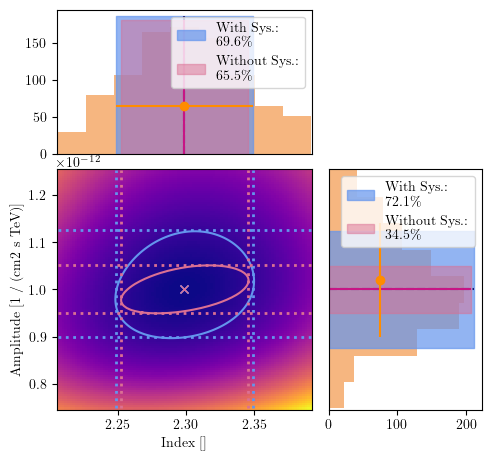

In [27]:
color_rnd = "sandybrown"
color_rnd_err = "darkorange"
alpha_nui = 0.7
alpha_st = 0.5
legends = ["With Sys.:\n", "Without Sys.:\n"]

nbins = 20

(
    ampli_min_asimov_N,
    ampli_max_asimov_N,
    index_min_asimov_N,
    index_max_asimov_N,
    ampli_best_asimov_N,
    index_best_asimov_N,
) = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N, threshold_contour, find_min=True
)

fig, axs = plt.subplots(1, 1, figsize=(5.0, 5.0))
axs_L = axs


CS_N = plot_L(
    data_contour_N,
    indexy__new_N,
    amplix__new_N,
    threshold_contour,
    find_min=True,
    color=colors[1],
    ax=a,
    fig=fig,
    cbar=False,
    cmap=cmap,
)

dat_N = CS_N.allsegs[0][0]
axs_L.plot(dat_N[:, 0], dat_N[:, 1], color=colors[1])
axs_L.plot(dat[:, 0], dat[:, 1], color=colors[0])
axs_L.plot(index_best_asimov_N, ampli_best_asimov_N, "x", color=colors[1])
axs_L.plot(index_best_asimov, ampli_best_asimov, "x", color=colors[0])

plot_errors(
    axs_L,
    indexy__new,
    amplix__new,
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
    colors[0],
)

plot_errors(
    axs_L,
    indexy__new_N,
    amplix__new_N,
    ampli_min_asimov_N,
    ampli_max_asimov_N,
    index_min_asimov_N,
    index_max_asimov_N,
    ampli_best_asimov_N,
    index_best_asimov_N,
    colors[1],
)

xlims = [None, amplix__new_N, indexy__new_N]

axs_L.scatter(indices_data, amplitudes_data, marker=".", color=color_rnd, alpha=0.4)
axs_L.set_ylim(xlims[1][0], xlims[1][-1])
axs_L.set_xlim(xlims[2][0], xlims[2][-1])
off = 1e-14
axs_L.text(
    index_best_asimov_N,
    off + ampli_max_asimov_N,
    "$1\\sigma$",
    color=colors[1],
    fontsize="large",
)
axs_L.text(
    index_best_asimov_N,
    off + ampli_max_asimov,
    "$1\\sigma$",
    color=colors[0],
    fontsize="large",
)
axs_L.plot(
    [np.nan, np.nan],
    [ylim[0], ylim[1] + delta_ylim],
    alpha=alpha_nui,
    color=colors[1],
    label=legends[0] + f"{fraction_N:.3}\\%",
)
axs_L.plot(
    [np.nan, np.nan],
    [ylim[0], ylim[1] + delta_ylim],
    alpha=alpha_st,
    color=colors[0],
    label=legends[1] + f"{fraction:.3}\\%",
)
axs_L.legend()
axs_L.set_xlabel("Index []")
axs_L.set_ylabel("Amplitude [1/cm2 s TeV]")


# plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS." + picformat)
    fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS." + "png")
print(N)

amplitudes: 1.0198493652679062e-12 pm 1.2139588663841873e-13
index: 2.299060907169546 pm 0.050318968633481787
1000


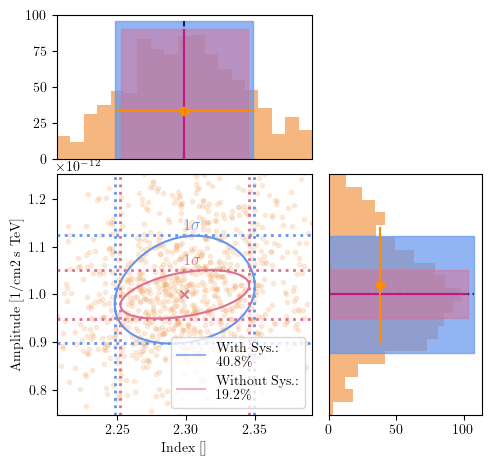

In [28]:
color_rnd = "sandybrown"
color_rnd_err = "darkorange"
alpha_nui = 0.7
alpha_st = 0.5
legends = ["With Sys.:\n", "Without Sys.:\n"]

nbins = 20
fig, axs = plt.subplots(1, 1, figsize=(5.0, 5.0))
axs_L = axs


# nui 1sigma
CS_N = plot_L(
    data_contour_N,
    indexy__new_N,
    amplix__new_N,
    threshold_contour,
    find_min=True,
    color=colors[1],
    ax=a,
    fig=fig,
    cbar=False,
    cmap=cmap,
)

dat_N = CS_N.allsegs[0][0]
axs_L.plot(dat_N[:, 0], dat_N[:, 1], color=colors[1])

# nui 2sigma
CS_N = plot_L(
    data_contour_N,
    indexy__new_N,
    amplix__new_N,
    2,
    find_min=True,
    color=colors[1],
    ax=a,
    fig=fig,
    cbar=False,
    cmap=cmap,
)

dat_N = CS_N.allsegs[0][0]
axs_L.plot(dat_N[:, 0], dat_N[:, 1], color=colors[1], linestyle="dotted")

# st 1sigma
CS = plot_L(
    data_contour,
    indexy__new,
    amplix__new,
    threshold_contour,
    find_min=True,
    color=colors[1],
    ax=a,
    fig=fig,
    cbar=False,
    cmap=cmap,
)

dat = CS.allsegs[0][0]
axs_L.plot(dat[:, 0], dat[:, 1], color=colors[0])

# st 2sigma
CS = plot_L(
    data_contour,
    indexy__new,
    amplix__new,
    2,
    find_min=True,
    color=colors[1],
    ax=a,
    fig=fig,
    cbar=False,
    cmap=cmap,
)

dat = CS.allsegs[0][0]
axs_L.plot(dat[:, 0], dat[:, 1], color=colors[0], linestyle="dotted")

# axs_L.plot(dat[:,0],dat[:,1], color = colors[0])
axs_L.plot(index_best_asimov_N, ampli_best_asimov_N, "x", color=colors[1])
axs_L.plot(index_best_asimov, ampli_best_asimov, "x", color=colors[0])
xlims = [None, amplix__new_N, indexy__new_N]

axs_L.scatter(indices_data, amplitudes_data, marker=".", color=color_rnd, alpha=0.4)
axs_L.set_ylim(xlims[1][0], xlims[1][-1])
axs_L.set_xlim(xlims[2][0], xlims[2][-1])
off = 5e-15
axs_L.text(
    index_best_asimov_N,
    off + ampli_max_asimov_N,
    "$1\\sigma$",
    color=colors[1],
    fontsize="large",
)
axs_L.text(
    index_best_asimov_N,
    off + ampli_max_asimov,
    "$1\\sigma$",
    color=colors[0],
    fontsize="large",
)
axs_L.plot(
    [np.nan, np.nan],
    [ylim[0], ylim[1] + delta_ylim],
    alpha=alpha_nui,
    color=colors[1],
    label=legends[0] + f"{fraction_N:.3}\\%",
)
axs_L.plot(
    [np.nan, np.nan],
    [ylim[0], ylim[1] + delta_ylim],
    alpha=alpha_st,
    color=colors[0],
    label=legends[1] + f"{fraction:.3}\\%",
)
axs_L.legend()
axs_L.set_xlabel("Index []")
axs_L.set_ylabel("Amplitude [1/cm2 s TeV]")


# plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS2." + picformat)
    fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS2." + "png")
print(N)

0 Best Fit BKG Norm
1 Best Fit Amplitude
2 Best Fit Index


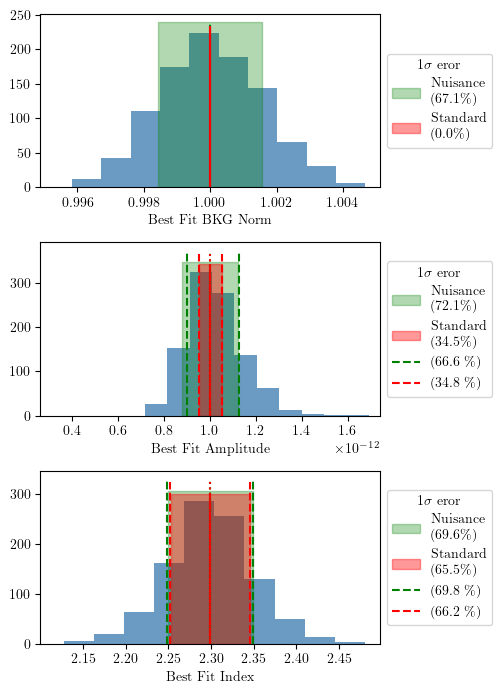

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(4, 7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]
legends = [
    "Nuisance",
    "Standard",
]

for i, v in enumerate(valuies):
    print(i, xlabels[i])
    axs[i].hist(v[1:, 0], color="steelblue", alpha=0.8)
    ylim = axs[i].get_ylim()
    delta_ylim = 5

    axs[i].vlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color="green",
        linestyle="dashed",
    )
    axs[i].fill_between(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=0.3,
        color="green",
        label=legends[0] + f" \n({withins[i][1]*100 :.3}\\%)",
    )
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color="red")
    axs[i].fill_between(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=0.4,
        color="red",
        label=legends[1] + f" \n({withins[i][0]*100 :.3}\\%)",
    )

    axs[i].set_xlabel(xlabels[i])

    x = axs[i].get_xlim()
    deltax = np.max([valuies_asimov[i][0] - x[0], x[1] - valuies_asimov[i][0]])
    axs[i].set_xlim(valuies_asimov[i][0] - deltax, valuies_asimov[i][0] + deltax)

ylim = axs[1].get_ylim()
delta_ylim = 9
axs[1].vlines(
    ampli_min_asimov_N, ylim[0], ylim[1] + delta_ylim, color="green", linestyle="dashed"
)
axs[1].vlines(
    ampli_max_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color="green",
    linestyle="dashed",
    label=f"({withins[1][3]*100:.3} \\%)",
)
axs[1].vlines(
    ampli_best_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color="green",
    linestyle="dotted",
)

delta_ylim = 2
axs[1].vlines(
    ampli_min_asimov, ylim[0], ylim[1] + delta_ylim, color="red", linestyle="dashed"
)
axs[1].vlines(
    ampli_max_asimov,
    ylim[0],
    ylim[1] + delta_ylim,
    color="red",
    linestyle="dashed",
    label=f"({withins[1][2]*100:.3} \\%)",
)
axs[1].vlines(
    ampli_best_asimov, ylim[0], ylim[1] + delta_ylim, color="red", linestyle="dotted"
)

ylim = axs[2].get_ylim()
delta_ylim = 9

axs[2].vlines(
    index_min_asimov_N, ylim[0], ylim[1] + delta_ylim, color="green", linestyle="dashed"
)
axs[2].vlines(
    index_max_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color="green",
    linestyle="dashed",
    label=f"({withins[2][3]*100:.3} \\%)",
)
axs[2].vlines(
    index_best_asimov_N,
    ylim[0],
    ylim[1] + delta_ylim,
    color="green",
    linestyle="dotted",
)
delta_ylim = 2
axs[2].vlines(
    index_min_asimov, ylim[0], ylim[1] + delta_ylim, color="red", linestyle="dashed"
)
axs[2].vlines(
    index_max_asimov,
    ylim[0],
    ylim[1] + delta_ylim,
    color="red",
    linestyle="dashed",
    label=f"({withins[2][2]*100:.3} \\%)",
)
axs[2].vlines(
    index_best_asimov, ylim[0], ylim[1] + delta_ylim, color="red", linestyle="dotted"
)
plt.tight_layout()
for a in axs:
    a.legend(title="1$\\sigma$ eror", loc="center left", bbox_to_anchor=(1, 0.5))

## Random with nuisacen Parameters

In [92]:


shift_rnd = 0.034394
tilt_rnd = -0.0147631

# shift_rnd  = random.choice(shift_rnds)
# tilt_rnd = random.choice(index_rnds)

fluxpoints = FluxPoints.read(
    f"data/fluxpoints/6_fluxpoints_{shift_rnd:.6}_{tilt_rnd:.6}.fits"
)
fluxpoints_N = FluxPoints.read(
    f"data/fluxpoints/6_fluxpoints_N_{shift_rnd:.6}_{tilt_rnd:.6}.fits"
)
model_name = f"data/fluxpoints/6_fluxpointsds_N_{shift_rnd:.6}_{tilt_rnd:.6}.yaml"
fluxpoints_Nds = FluxPointsDataset(data=fluxpoints_N, models=Models.read(model_name))
model_name = f"data/fluxpoints/6_fluxpointsds_{shift_rnd:.6}_{tilt_rnd:.6}.yaml"
fluxpoints_ds = FluxPointsDataset(data=fluxpoints, models=Models.read(model_name))

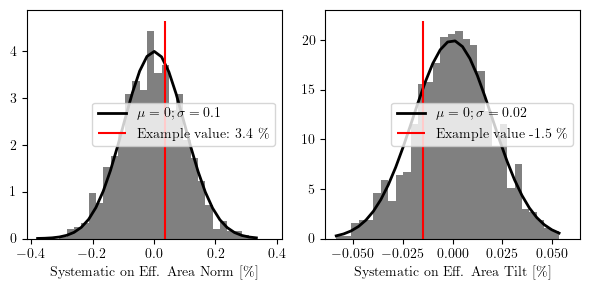

In [93]:
fig, (axs, ax1) = plt.subplots(1, 2, figsize=(6, 3))
nbins = 30
count, bins, ignored = axs.hist(shift_rnds, nbins, density=True, color="grey")
sigma = shift
mu = 0
axs.plot(
    bins,
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
    linewidth=2,
    color="black",
    label=f"$\\mu = {mu}; \\sigma = {sigma}$",
)

axs.vlines(
    shift_rnd,
    0,
    axs.get_ylim()[1],
    color="red",
    label=f"Example value: {shift_rnd*100:.2} \\%",
)

axs.set_xlabel("Systematic on Eff. Area Norm [\\%]")
axs.legend(loc="center right")

x = axs.get_xlim()
deltax = np.max([mu - x[0], x[1] - mu])
axs.set_xlim(mu - deltax, mu + deltax)


count, bins, ignored = ax1.hist(index_rnds, nbins, density=True, color="grey")
sigma = tilt
mu = 0
ax1.plot(
    bins,
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
    linewidth=2,
    color="black",
    label=f"$\\mu = {mu}; \\sigma = {sigma:.3}$",
)
ax1.vlines(
    tilt_rnd,
    0,
    ax1.get_ylim()[1],
    color="red",
    label=f"Example value {tilt_rnd*100:.2} \\%",
)

ax1.set_xlabel("Systematic on Eff. Area Tilt [\\%]")
# ax1.set_title(f"N = {N}")
ax1.legend(loc="center right")

x = ax1.get_xlim()
deltax = np.max([mu - x[0], x[1] - mu])
ax1.set_xlim(mu - deltax, mu + deltax)
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7c_rnd_sys_{shift}." + picformat)
    fig.savefig(f"plots/7c_rnd_sys_{shift}.pdf")

In [94]:
pars_N = np.loadtxt("data/7a_N_P_draw_par.txt")
flux_N = np.loadtxt("data/7a_N_P_draw_flux.txt")
flux2e_N = np.loadtxt("data/7a_N_P_draw_flux2e.txt")


lem = len(pars_N)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
stat_sums = infos[:N_max, 2]


# amplitude', 'index', 'norm', 'tilt
amplitudes_N = pars_N[:N_max, 0:2]
indices_N = pars_N[:N_max, 2:4]
norms_N = pars_N[:N_max, 4:6]
tilts_N = pars_N[:N_max, 6:8]
norm_nuisance_N = pars_N[:N_max, 8:10]
tilt_nuisance_N = pars_N[:N_max, 10:12]

valuies_N = [norms_N, amplitudes_N, indices_N, norm_nuisance_N, tilt_nuisance_N]


amplitudes_data_N = valuies_N[1][:, 0]
indices_data_N = valuies_N[2][:, 0]

1000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Norm nuisance error: 0.111 pm 0.0283
Tilt nuisance error: 0.0208 pm 0.031


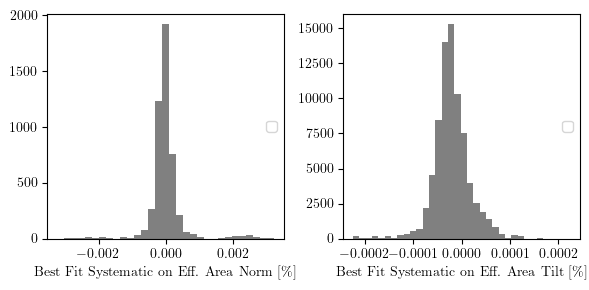

In [95]:
fig, (axs, ax1) = plt.subplots(1, 2, figsize=(6, 3))
nbins = 30
count, bins, ignored = axs.hist(
    norm_nuisance_N[:, 0], nbins, density=True, color="grey"
)

axs.set_xlabel("Best Fit Systematic on Eff. Area Norm [\\%]")
axs.legend(loc="center right")

x = axs.get_xlim()
deltax = np.max([mu - x[0], x[1] - mu])
axs.set_xlim(mu - deltax, mu + deltax)

count, bins, ignored = ax1.hist(
    tilt_nuisance_N[:, 0], nbins, density=True, color="grey"
)

ax1.set_xlabel("Best Fit Systematic on Eff. Area Tilt [\\%]")
# ax1.set_title(f"N = {N}")
ax1.legend(loc="center right")

x = ax1.get_xlim()
deltax = np.max([mu - x[0], x[1] - mu])
ax1.set_xlim(mu - deltax, mu + deltax)
plt.tight_layout()

print(
    f"Norm nuisance error: {np.mean(norm_nuisance_N[:,1]):.3} pm {np.std(norm_nuisance_N[:,1]):.3}"
)
print(
    f"Tilt nuisance error: {np.mean(tilt_nuisance_N[:,1]):.3} pm {np.std(tilt_nuisance_N[:,1]):.3}"
)

In [96]:
def plot_amplitude(axs_a):
    # ampli
    a = axs_a
    i = 1
    a.hist(
        valuies[i][1:, 0],
        color=color_rnd,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
        orientation="horizontal",
    )

    a.hist(
        valuies_N[i][1:, 0],
        color=color_rnd_nui,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
        orientation="horizontal",
    )

    ylim = a.get_xlim()
    delta_ylim = 5
    a.hlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color=colors[1],
        linestyle="dashed",
    )
    a.fill_betweenx(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=alpha_nui,
        color=colors[3],
        label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
    )
    a.hlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
    a.fill_betweenx(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=alpha_st,
        color=colors[2],
        label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
    )
    a.set_xlabel("")
    a.set_ylim(axs_L.get_ylim()[0], axs_L.get_ylim()[1])
    yy = a.get_xlim()[1]
    print(
        f"amplitudes  : {np.mean(amplitudes[:,0]):.5} pm {np.std(amplitudes[:,0]):.5}"
    )
    print(
        f"amplitudes N: {np.mean(amplitudes_N[:,0]):.5} pm {np.std(amplitudes_N[:,0]):.5}"
    )

    a.errorbar(
        x=yy / 3,
        y=np.mean(amplitudes[:, 0]),
        yerr=np.std(amplitudes[:, 0]),
        fmt="o",
        color=color_rnd_err,
        label="",
    )

    a.errorbar(
        x=yy / 3 - y2,
        y=np.mean(amplitudes_N[:, 0]),
        yerr=np.std(amplitudes_N[:, 0]),
        fmt="o",
        color=color_rnd_nui_err,
        label="",
    )

    a.set_yticklabels([])
    a.set_yticks([])


def plot_index(axs_i):
    # index
    a = axs_i
    i = 2
    a.hist(
        valuies[i][1:, 0],
        color=color_rnd,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
    )
    a.hist(
        valuies_N[i][1:, 0],
        color=color_rnd_nui,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
    )
    ylim = a.get_ylim()
    delta_ylim = 5
    a.vlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color=colors[1],
        linestyle="dashed",
    )
    a.fill_between(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=alpha_nui,
        color=colors[3],
        label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
    )
    a.vlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
    a.fill_between(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=alpha_st,
        color=colors[2],
        label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
    )
    a.set_xlabel(xlabels[i])
    yy = a.get_ylim()[1]
    print(f"index     : {np.mean(indices[:,0]):.5} pm {np.std(indices[:,0]):.5}")
    print(f"index nui : {np.mean(indices_N[:,0]):.5} pm {np.std(indices_N[:,0]):.5}")
    a.errorbar(
        x=np.mean(indices[:, 0]),
        y=yy / 3,
        xerr=np.std(indices[:, 0]),
        fmt="o",
        color=color_rnd_err,
        label="",
    )
    a.errorbar(
        x=np.mean(indices_N[:, 0]),
        y=yy / 3 - y2,
        xerr=np.std(indices_N[:, 0]),
        fmt="o",
        color=color_rnd_nui_err,
        label="",
    )
    a.set_xlim(axs_L.get_xlim()[0], axs_L.get_xlim()[1])
    a.set_xlabel("")
    a.set_xticklabels([])
    a.set_xticks([])

In [97]:
colors = ["crimson", "midnightblue", "red", "cornflowerblue"]

color_rnd = "darkorange"
color_rnd_example = "darkorange"
color_rnd_err = "darkorange"

color_rnd_nui = "forestgreen"
color_rnd_nui_example = "forestgreen"
color_rnd_nui_err = "forestgreen"


alpha_nui = 0.7
alpha_st = 0.5
legends = ["Asimov with Nuisnace", "Asimov"]

alpha_rnd = 0.3
alpha_rnd_nui = 0.3


nbins = 20

1000


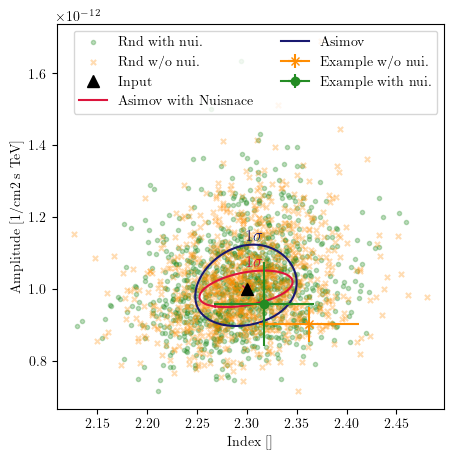

In [98]:
fig, axs_L = plt.subplots(1, 1, figsize=(5.0, 5.0))


def plot_randoms(axs_L, fig):
    (
        ampli_min_asimov_N,
        ampli_max_asimov_N,
        index_min_asimov_N,
        index_max_asimov_N,
        ampli_best_asimov_N,
        index_best_asimov_N,
    ) = compute_errors(
        data_contour_N, indexy__new_N, amplix__new_N, threshold_contour, find_min=True
    )

    CS_N = plot_L(
        data_contour_N,
        indexy__new_N,
        amplix__new_N,
        threshold_contour,
        find_min=True,
        color=colors[1],
        ax=a,
        fig=fig,
        cbar=False,
        cmap=cmap,
    )
    dat_N = CS_N.allsegs[0][0]
    axs_L.plot(dat_N[:, 0], dat_N[:, 1], color=colors[1])

    CS = plot_L(
        data_contour,
        indexy__new,
        amplix__new,
        threshold_contour,
        find_min=True,
        color=colors[1],
        ax=a,
        fig=fig,
        cbar=False,
        cmap=cmap,
    )
    dat = CS.allsegs[0][0]
    axs_L.plot(dat[:, 0], dat[:, 1], color=colors[0])
    axs_L.plot(index_best_asimov, ampli_best_asimov, "x", color=colors[0])

    axs_L.scatter(
        indices_data_N,
        amplitudes_data_N,
        marker=".",
        color=color_rnd_nui,
        alpha=alpha_rnd_nui,
        label="Rnd with nui.",
    )
    axs_L.scatter(
        indices_data,
        amplitudes_data,
        marker="x",
        s=14,
        color=color_rnd,
        alpha=alpha_rnd,
        label="Rnd w/o nui.",
    )

    model = fluxpoints_ds.models[0]
    ampli, index = model.parameters["amplitude"].value, model.parameters["index"].value
    ampli_err, index_err = (
        model.parameters["amplitude"].error,
        model.parameters["index"].error,
    )
    axs_L.errorbar(
        index,
        ampli,
        xerr=index_err,
        yerr=ampli_err,
        marker="x",
        markersize=6,
        color=color_rnd_example,
        alpha=0.99,
        label="Example w/o nui.",
    )

    model = fluxpoints_Nds.models[0]
    ampli, index = model.parameters["amplitude"].value, model.parameters["index"].value
    ampli_err, index_err = (
        model.parameters["amplitude"].error,
        model.parameters["index"].error,
    )

    axs_L.errorbar(
        index,
        ampli,
        xerr=index_err,
        yerr=ampli_err,
        marker="o",
        markersize=6,
        color=color_rnd_nui_example,
        alpha=0.99,
        label="Example with nui.",
    )

    axs_L.plot(2.3, 1e-12, "^", markersize=9, color="black", label="Input")

    off = 1e-14
    axs_L.text(
        index_best_asimov_N,
        off + ampli_max_asimov_N,
        "$1\\sigma$",
        color=colors[1],
        fontsize="large",
    )
    axs_L.text(
        index_best_asimov_N,
        off + ampli_max_asimov,
        "$1\\sigma$",
        color=colors[0],
        fontsize="large",
    )
    axs_L.plot(
        [np.nan, np.nan],
        [ylim[0], ylim[1] + delta_ylim],
        alpha=1,
        color=colors[0],
        label=legends[0],
    )  # + f'{fraction_N:.3}\\%')
    axs_L.plot(
        [np.nan, np.nan],
        [ylim[0], ylim[1] + delta_ylim],
        alpha=1,
        color=colors[1],
        label=legends[1],
    )  # +  f'{fraction:.3}\\%'  )
    axs_L.legend(ncol=2)
    axs_L.set_xlabel("Index []")
    axs_L.set_ylabel("Amplitude [1/cm2 s TeV]")

    # plt.tight_layout()
    if savefig:
        fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS_nui." + picformat)
        fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS_nui." + "png")
    print(N)
    return fig


fig = plot_randoms(axs_L, fig)

1000
amplitudes  : 1.0198e-12 pm 1.214e-13
amplitudes N: 1.0156e-12 pm 1.2325e-13
index     : 2.2991 pm 0.050319
index nui : 2.2965 pm 0.049858
1000


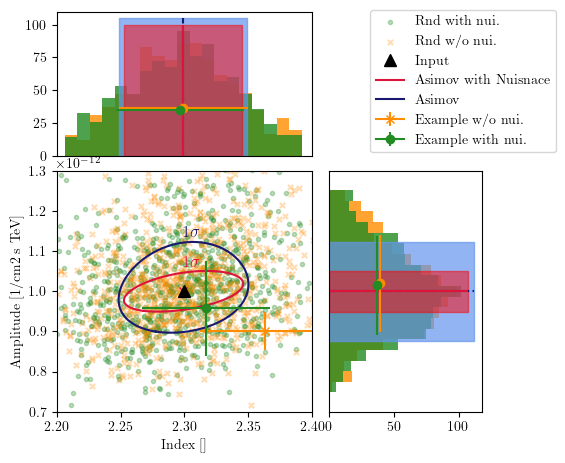

In [99]:
y2 = 2
fig, axs = plt.subplots(
    2,
    2,
    gridspec_kw={"height_ratios": [3, 5], "width_ratios": [5, 3]},
    figsize=(5.0, 5.0),
)
axs_L = axs[1][0]
axs_i = axs[0][0]
axs_a = axs[1][1]
axs[0, -1].axis("off")

fig = plot_randoms(axs_L, fig)
axs_L.set_ylim(0.7e-12, 1.3e-12)
axs_L.set_xlim(2.2, 2.4)


plot_amplitude(axs_a)
plot_index(axs_i)


plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.08, hspace=0.08)
axs_L.legend(bbox_to_anchor=(1.2, 1.7))


# plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{shift}_dist_nui." + picformat)
    fig.savefig(f"plots/7c_L_contour_{shift}_dist_nui." + "png")
print(N)

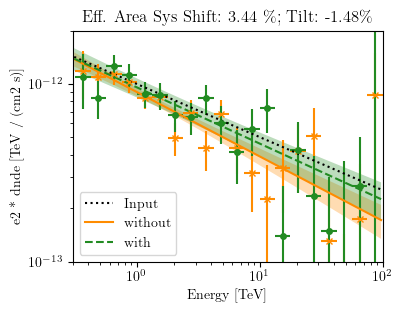

In [100]:


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
fluxpoints_ds.data.plot(energy_power=2, ax=ax, color=color_rnd, label="", marker="x")
fluxpoints_Nds.data.plot(energy_power=2, ax=ax, color=color_rnd_nui, label="")

model = dataset_asimov.models[0]
info = f"$\\phi_0$={model.parameters['amplitude'].value:.2}\n  {model.parameters['amplitude'].unit}"
info += f"\n$\\Gamma$={model.parameters['index'].value:.2}  {model.parameters['index'].unit}"
dataset_asimov.models[0].spectral_model.plot(
    energy_bounds=[0.3, 100] * u.TeV,
    energy_power=2,
    ax=ax,
    color="black",
    label="Input",
    linestyle="dotted",
)


model = fluxpoints_ds.models[0]
info = f"$\\phi_0$={model.parameters['amplitude'].value:.2} $\\pm$"
info += (
    f"{model.parameters['amplitude'].error:.2}\n  {model.parameters['amplitude'].unit}"
)
info += f"\n$\\Gamma$={model.parameters['index'].value:.2} $\\pm$"
info += f"{model.parameters['index'].error:.2}  {model.parameters['index'].unit}"
fluxpoints_ds.models[0].spectral_model.plot(
    energy_bounds=[0.3, 100] * u.TeV,
    energy_power=2,
    ax=ax,
    color=color_rnd,
    label="without",
)
fluxpoints_ds.models[0].spectral_model.plot_error(
    energy_bounds=[0.3, 100] * u.TeV,
    energy_power=2,
    ax=ax,
    facecolor=color_rnd_err,
    label="",
    alpha=0.3,
)

model = fluxpoints_Nds.models[0]
info = f"$\\phi_0$={model.parameters['amplitude'].value:.2} $\\pm$"
info += (
    f"{model.parameters['amplitude'].error:.2}\n  {model.parameters['amplitude'].unit}"
)
info += f"\n$\\Gamma$={model.parameters['index'].value:.2} $\\pm$"
info += f"{model.parameters['index'].error:.2}  {model.parameters['index'].unit}"
fluxpoints_Nds.models[0].spectral_model.plot(
    energy_bounds=[0.3, 100] * u.TeV,
    energy_power=2,
    ax=ax,
    color=color_rnd_nui,
    label="with",
    linestyle="dashed",
)
fluxpoints_Nds.models[0].spectral_model.plot_error(
    energy_bounds=[0.3, 100] * u.TeV,
    energy_power=2,
    ax=ax,
    facecolor=color_rnd_nui_err,
    label="",
    alpha=0.3,
)


ax.set_title(
    f"Eff. Area Sys Shift: {shift_rnd*100:.3} \\%; Tilt: {tilt_rnd*100:.3}\\% "
)

# ax.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.6), ncol = 3)
ax.legend(loc="lower left")

# ax.legend()
# plt.tight_layout()
ax.set_xlim(0.3, 100)
ax.set_ylim(1e-13, 2e-12)
fig.savefig("plots/7c_fluxpoint_example.pdf", bbox_inches="tight")
fig.savefig("plots/7c_fluxpoint_example.png", bbox_inches="tight")

## Input Within Rnd Results

In [101]:
a_within, i_within = [], []
a_within_N, i_within_N = [], []

a_input = dataset_asimov.models.parameters["amplitude"].value
i_input = dataset_asimov.models.parameters["index"].value

for a_ in amplitudes:
    a_within.append(((a_[0] - a_[1]) <= a_input) and ((a_[0] + a_[1]) >= a_input))
for i_ in indices:
    i_within.append(((i_[0] - i_[1]) <= i_input) and ((i_[0] + i_[1]) >= i_input))

for a_ in amplitudes_N:
    a_within_N.append(((a_[0] - a_[1]) <= a_input) and ((a_[0] + a_[1]) >= a_input))
for i_ in indices_N:
    i_within_N.append(((i_[0] - i_[1]) <= i_input) and ((i_[0] + i_[1]) >= i_input))

In [102]:
print(sum(a_within) / len(a_within))
print(sum(i_within) / len(i_within))

0.342
0.665


In [103]:
print(sum(a_within_N) / len(a_within_N))
print(sum(i_within_N) / len(i_within_N))

0.724
0.694
